## Long Short-Term Memory (LSTM)

Predicting sales on time-series data with the Recurrent Neural Network LSTM model

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
df = pd.read_csv('/home/praveent/Predicting_sales_on_time_series_data_with_Recurrent_Neural_Network_LSTM_Model/Project1_Predicting_Sales_Time_Series_Data/Alcohol_Sales.csv',index_col=0,parse_dates=True)
df.head()


,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [12]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

In [14]:
df.index.freq='MS'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


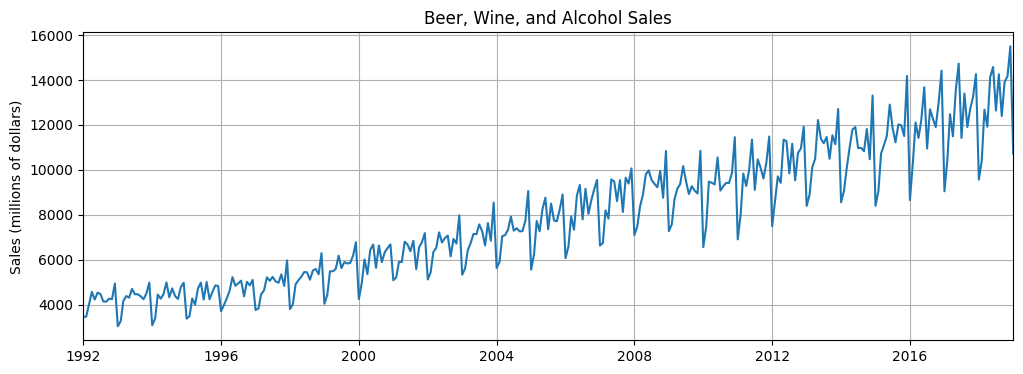

In [5]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

In [7]:
y = df['S4248SM144NCEN'].values.astype(float)
y[:10]

array([3459., 3458., 4002., 4564., 4221., 4529., 4466., 4137., 4126.,
       4259.])

In [8]:
test_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [28]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [30]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [17]:
window_size = 12

In [20]:
def input_data(seq, ws):
  out = []
  L=len(seq)

  for i in range(L-ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    out.append((window,label))

  return out

train_data = input_data(train_norm, window_size)
len(train_data)

301

In [21]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

LSTM Architecture
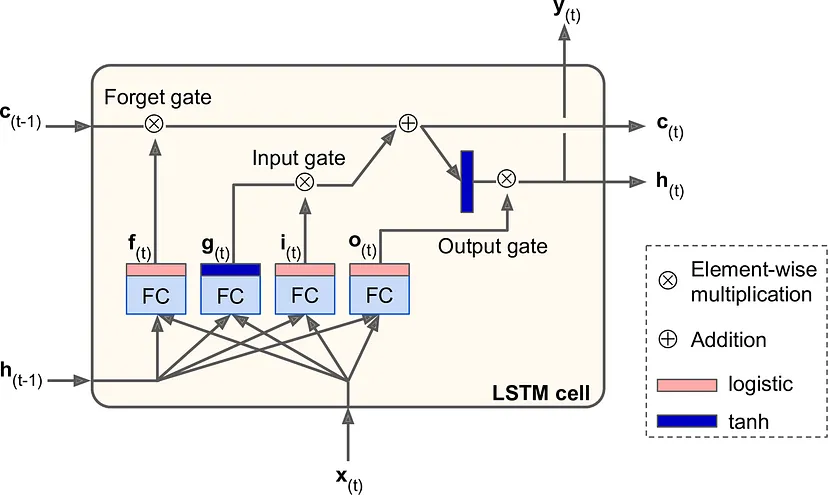

In [22]:
class LSTMnet(nn.Module):
  def __init__(self, input_size=1, hidden_size=100, out_size=1):
    super().__init__()
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size, hidden_size)
    self.linear = nn.Linear(hidden_size, out_size)
    self.hidden = (torch.zeros(1,1, hidden_size),
                   torch.zeros(1,1, hidden_size)) # (H, C)

  def forward(self, seq):

    lstm_out, self.hidden = self.lstm(
        seq.view(len(seq), 1, -1),
        self.hidden)                               #Input===(X,H,C), Output ===(y,H,c)
    pred = self.linear(lstm_out.view(len(seq), -1))
    return pred[-1]

In [23]:
torch.manual_seed(42)

model = LSTMnet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
model

LSTMnet(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [25]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
  for seq, y_train in train_data:

    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    y_pred = model(seq)                         # forword pass
    loss = criterion(y_pred, y_train)
    loss.backward()                             # Backword pass
    optimizer.step()                            # Optimize parameter

  print(f"Epoch: {epoch} | Loss: {loss.item()}")


total_time = time.time() - start_time
print(f"Total time in minutes: {total_time/60}")

Epoch: 0 | Loss: 0.26208415627479553
Epoch: 1 | Loss: 0.34071704745292664
Epoch: 2 | Loss: 0.3732522428035736
Epoch: 3 | Loss: 0.37144583463668823
Epoch: 4 | Loss: 0.32069429755210876
Epoch: 5 | Loss: 0.33051443099975586
Epoch: 6 | Loss: 0.32643330097198486
Epoch: 7 | Loss: 0.3249703347682953
Epoch: 8 | Loss: 0.3068375587463379
Epoch: 9 | Loss: 0.30106237530708313
Epoch: 10 | Loss: 0.29293543100357056
Epoch: 11 | Loss: 0.286001980304718
Epoch: 12 | Loss: 0.2946683466434479
Epoch: 13 | Loss: 0.27528756856918335
Epoch: 14 | Loss: 0.2910606861114502
Epoch: 15 | Loss: 0.2763768136501312
Epoch: 16 | Loss: 0.2857089340686798
Epoch: 17 | Loss: 0.28756284713745117
Epoch: 18 | Loss: 0.2682705819606781
Epoch: 19 | Loss: 0.2668338716030121
Epoch: 20 | Loss: 0.26333287358283997
Epoch: 21 | Loss: 0.26538383960723877
Epoch: 22 | Loss: 0.25447317957878113
Epoch: 23 | Loss: 0.2700851559638977
Epoch: 24 | Loss: 0.1340501457452774
Epoch: 25 | Loss: 2.7761716410168447e-05
Epoch: 26 | Loss: 0.001132274628

In [31]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])

  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    preds.append(model(seq).item())
 
# Predicted values
preds[window_size:]    

[0.49661925435066223,
 0.5924646854400635,
 0.584254264831543,
 0.7883567810058594,
 1.0312211513519287,
 0.46857306361198425,
 0.7241657972335815,
 0.6063885688781738,
 0.6665273904800415,
 0.7775094509124756,
 1.039047360420227,
 0.14090271294116974]

In [33]:
# Need for inverse the normalization, to obtain real values
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
true_predictions

array([[11785.47432832],
       [12346.12217748],
       [12298.09532213],
       [13491.99299049],
       [14912.62812483],
       [11621.4181356 ],
       [13116.50783092],
       [12427.56993365],
       [12779.35197061],
       [13428.54153311],
       [14958.40753478],
       [ 9704.71041935]])

In [34]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Freq: MS, Name: S4248SM144NCEN, dtype: int64

In [42]:
# Add date timestamps
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [43]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq='MS')

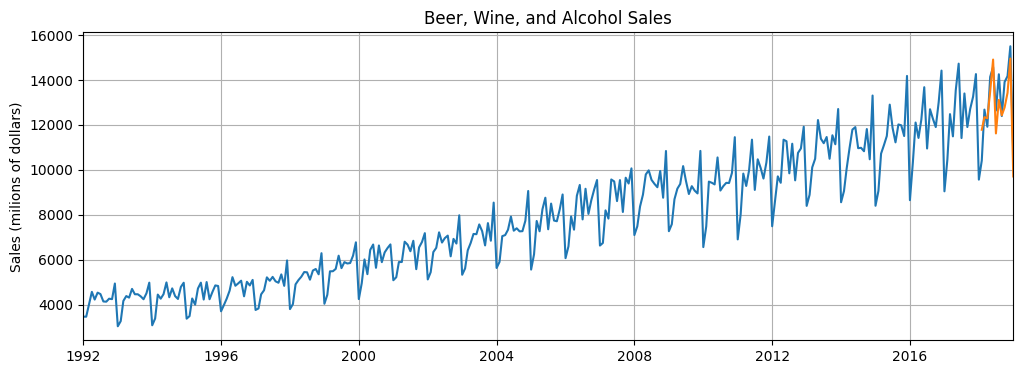

In [44]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (milions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_predictions)
plt.show()

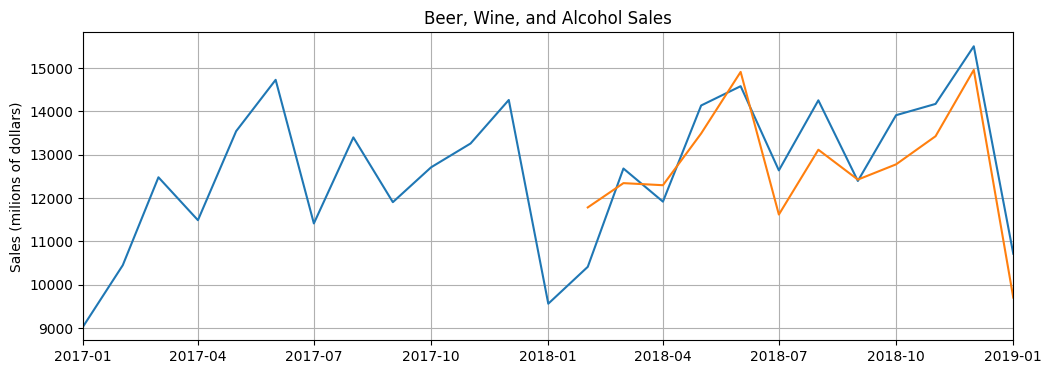

In [45]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (milions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

# Zoom in predictions
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x, true_predictions)
plt.show()

## Forcast predictions

In [46]:
torch.manual_seed(42)
epochs = 100

model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size)

for epoch in range(epochs):
  for seq, y_train in all_data:

    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch+1:2} | Loss: {loss.item():10.8f}")


Epoch:  1 | Loss: 0.04812275
Epoch:  2 | Loss: 0.07954498
Epoch:  3 | Loss: 0.03001836
Epoch:  4 | Loss: 0.04101092
Epoch:  5 | Loss: 0.01978551
Epoch:  6 | Loss: 0.02344561
Epoch:  7 | Loss: 0.02762611
Epoch:  8 | Loss: 0.01305061
Epoch:  9 | Loss: 0.00834248
Epoch: 10 | Loss: 0.00353559
Epoch: 11 | Loss: 0.01325114
Epoch: 12 | Loss: 0.00056932
Epoch: 13 | Loss: 0.00999405
Epoch: 14 | Loss: 0.01694059
Epoch: 15 | Loss: 0.01579788
Epoch: 16 | Loss: 0.00774884
Epoch: 17 | Loss: 0.00739562
Epoch: 18 | Loss: 0.01466390
Epoch: 19 | Loss: 0.00046236
Epoch: 20 | Loss: 0.02708882
Epoch: 21 | Loss: 0.00160224
Epoch: 22 | Loss: 0.00001700
Epoch: 23 | Loss: 0.00394348
Epoch: 24 | Loss: 0.00026816
Epoch: 25 | Loss: 0.00796444
Epoch: 26 | Loss: 0.00237127
Epoch: 27 | Loss: 0.00360927
Epoch: 28 | Loss: 0.01521640
Epoch: 29 | Loss: 0.00029007
Epoch: 30 | Loss: 0.01255869
Epoch: 31 | Loss: 0.02345235
Epoch: 32 | Loss: 0.00156564
Epoch: 33 | Loss: 0.00614578
Epoch: 34 | Loss: 0.01030684
Epoch: 35 | Lo

In [47]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])

  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    preds.append(model(seq).item())


In [48]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))

In [49]:
true_predictions

array([[10415.00001808],
       [12683.00013363],
       [11919.00006013],
       [14137.99993426],
       [14583.00009555],
       [12640.00017402],
       [14257.00005591],
       [12395.9999277 ],
       [13913.99994579],
       [14173.99995232],
       [15504.        ],
       [10717.99998423],
       [11053.33225703],
       [13215.21389422],
       [12884.46879303],
       [14229.24488431],
       [14274.09045541],
       [13821.2030465 ],
       [14957.1258021 ],
       [14647.85781968],
       [15363.07631862],
       [15152.9561463 ],
       [16932.30181313],
       [10863.48016997]])

In [50]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]')
x

array(['2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
       '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01'],
      dtype='datetime64[M]')

In [51]:
true_predictions[window_size:]

array([[11053.33225703],
       [13215.21389422],
       [12884.46879303],
       [14229.24488431],
       [14274.09045541],
       [13821.2030465 ],
       [14957.1258021 ],
       [14647.85781968],
       [15363.07631862],
       [15152.9561463 ],
       [16932.30181313],
       [10863.48016997]])

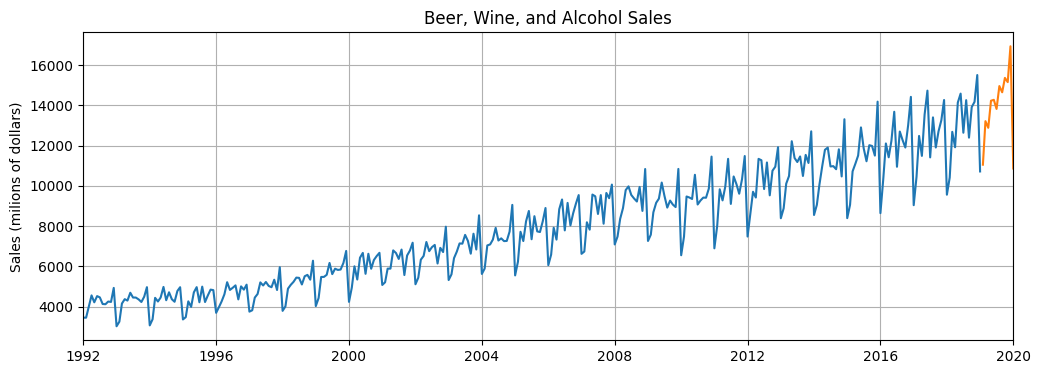

In [52]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (milions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_predictions[window_size:])
plt.show()

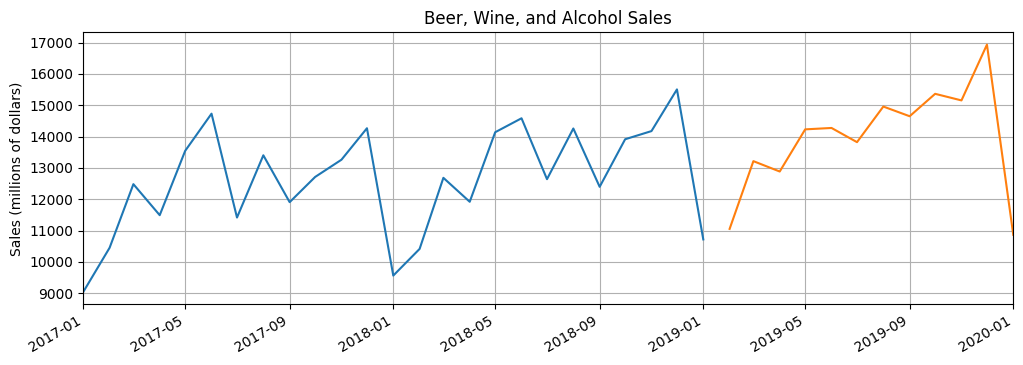

In [53]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()